# Principal component analisys 

In [ ]:
import torch
import torchvision
import numpy as np

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Image loading

In [3]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((32,32), (0.90,1)),
    transforms.RandomRotation((-5,  5))
])     # Set mean to 0 and  var to 1

images, labels = torch.load('./.data/MNIST32_train.pkl')
#images = transform(images) 

all_train = torch.utils.data.TensorDataset(images, labels) 
train_size = int(0.9 * len(all_train))
val_size = len(all_train) - train_size

train_set, val_set = torch.utils.data.random_split(all_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

images, labels = torch.load('./.data/MNIST32_val.pkl')
#images = transform(images) 

test_data = torch.utils.data.TensorDataset(images, labels)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

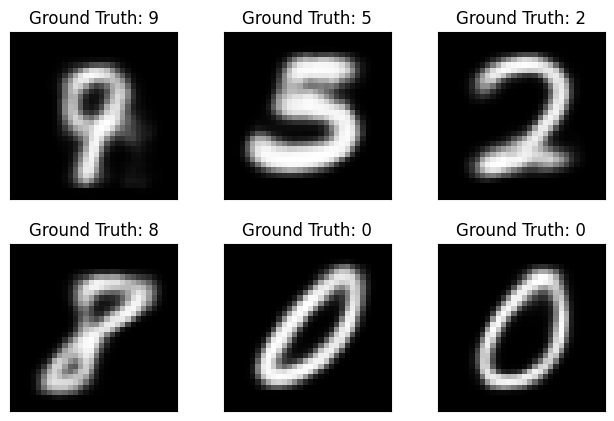

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## Loading the classifier

In [5]:
classifier = torch.load(".checkpoint/model_checkpoint.pt",weights_only=False)
print(classifier)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


Here i selected only the layers up to but excluding softmax

In [7]:
encoder = classifier[:11]
encoder.to(device, non_blocking = True)
print(encoder)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
)


## PCA on original images

In [9]:
from sklearn.decomposition import PCA

latents = []
labels = []

encoder.eval()

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device, non_blocking = True)
        z = encoder(x)
        latents.append(z.cpu())
        labels.append(y)

latents, labels = torch.cat(latents), torch.cat(labels)

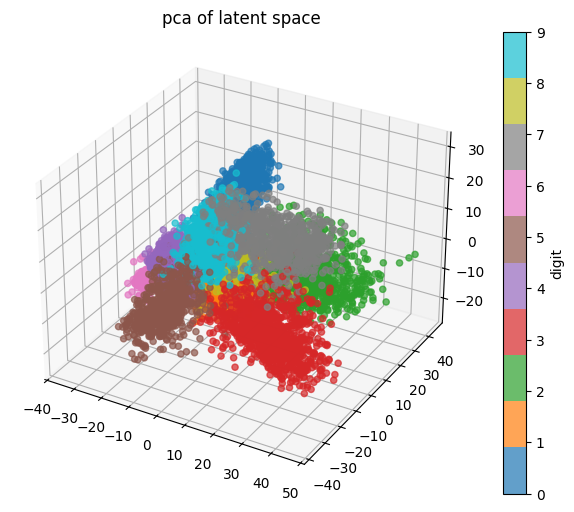

In [21]:
pca = PCA(random_state=42)
latents_3d = pca.fit_transform(latents)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2], c=labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="digit")
plt.title("pca of latent space")
plt.show()

In [23]:
tot_variance = 0
for var in pca.explained_variance_:
    tot_variance += var
tot_variance

np.float64(1004.4246965931924)

In [39]:
explained_variance = 0

for pc, var in enumerate(pca.explained_variance_):
    pc += 1
    explained_variance += var / tot_variance

    if pc == 3:
        break

print(f"Numero di componenti che spiegano {explained_variance * 100:.1f} % della varianza = {pc}")

Numero di componenti che spiegano 57.9 % della varianza = 3


In [40]:
explained_variance = 0

for pc, var in enumerate(pca.explained_variance_):
    pc += 1
    explained_variance += var / tot_variance

    if explained_variance > 0.90:
        break

print(f"Numero di componenti che spiegano {explained_variance * 100:.1f} % della varianza = {pc}")

Numero di componenti che spiegano 90.4 % della varianza = 8


In [41]:
explained_variance = 0

for pc, var in enumerate(pca.explained_variance_):
    pc += 1
    explained_variance += var / tot_variance

    if explained_variance > 0.99:
        break

print(f"Numero di componenti che spiegano {explained_variance * 100:.1f} % della varianza = {pc}")

Numero di componenti che spiegano 99.0 % della varianza = 32


In [38]:
len(pca.explained_variance_)

84